In [2]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline
import plotly.express as px
import seaborn as sns
# pre
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format 
pd.set_option('display.max_rows' , None)
pd.set_option('display.max_columns' , None)

In [3]:
def find_highly_correlated_features(data, threshold=0.6):
    """
    Find and display highly correlated features in a dataset.

    Parameters:
    - data: pandas DataFrame
    - threshold: correlation threshold (default is 0.8)

    Returns:
    - List of tuples representing highly correlated feature pairs
    """
    corr_matrix = data.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find features with correlation above the threshold
    correlated_features = [(col1, col2) for col1 in upper_triangle.columns for col2 in upper_triangle.columns if upper_triangle.loc[col1, col2] > threshold]


    return correlated_features

In [4]:
# Read the data
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

# file with discribtion for each fatuer
var_def = pd.read_csv('VariableDescription.csv')


print("Train data shape : " ,train_df.shape)
print("Test data shape : " ,test_df.shape)

Train data shape :  (3870, 44)
Test data shape :  (1290, 43)


In [5]:
# Change the index of the VariableDescription file ,, to esay access leater...
var_def.set_index('Variable' , inplace=True)

In [6]:
# Concatenate the data to over view what's going on ...
train_df['Set'] = 'Train'
test_df['Set'] = 'Test'
df = pd.concat([train_df , test_df])
print('After Concatenation : ' , df.shape)

After Concatenation :  (5160, 45)


## **The data contain different types of features**
- **Data time features**
- **Categorical features**
- **Numerical features**


In [7]:
# Date time features 
date_col = [x for x in list(df.columns) if str(x).endswith('ate') ] + ['SeedingSowingTransplanting']
print('Numebr of datetime features : ' , len(date_col))
# Convert to datetime
for feat in date_col:
    df[feat] = pd.to_datetime(df[feat])

# Catogrical columns 
cat_col = df.select_dtypes(include=['O' , 'bool']).columns.to_list()
print('Numebr of catogrical features : ' , len(cat_col))


# Numerical featuers 
num_col = df.select_dtypes(exclude=['O' , 'bool' , 'datetime64[ns]']).columns.to_list()
print('Numebr of numerical features : ' , len(num_col))

print("Hint: The catogrical data dosen't contain features of order type.")

Numebr of datetime features :  5
Numebr of catogrical features :  19
Numebr of numerical features :  21
Hint: The catogrical data dosen't contain features of order type.


### **We have five date time features ,, talking about the cleander for rice cultivation cycle**
- **CropTillageDate : زمن حراثة الارض**
- **RcNursEstDate : زمن حضانة البذور** 
- **SeedingSowingTransplanting : زمن زراعة الشتل**
- **Harv_date: فترة الحصاد**
- **Threshing_date : فترة إعداد المحصول**

In [8]:
# We have five date time features
var_def.loc[date_col].T

Variable,CropTillageDate,RcNursEstDate,Harv_date,Threshing_date,SeedingSowingTransplanting
Description,Date of tillage of the largest plot,Date of nursery establishment,Date of harvesting,Date of threshing of harvested crop,Date of sowing/Transplanting the crop


In [9]:
# describtion about the top , first and last dates.. 
df[date_col].describe().T

,count,unique,top,freq,first,last
CropTillageDate,5160,80,2022-07-20,258,2022-05-08,2022-08-27
RcNursEstDate,5034,61,2022-06-28,295,2022-06-01,2022-07-31
Harv_date,5160,114,2022-11-05,240,2021-12-01,2023-03-18
Threshing_date,5160,166,2022-12-22,142,2022-10-01,2023-03-22
SeedingSowingTransplanting,5160,62,2022-07-28,264,2022-07-01,2022-08-31


In [10]:
# There is 126 out off 5160 null entery in RcNursEstDate 
df[date_col].isnull().sum()

CropTillageDate                 0
RcNursEstDate                 126
Harv_date                       0
Threshing_date                  0
SeedingSowingTransplanting      0
dtype: int64

#### **We can take the different between SeedingSowingTransplanting and RcNursEstDate as a new feature**  -->
**,, nursery_diff_sowing (25-35) days from the domain knowledg**

In [11]:
# New feature
df['nursery_diff_sowing'] = df['SeedingSowingTransplanting'] - df['RcNursEstDate']
df['nursery_diff_sowing'] = df['nursery_diff_sowing'].dt.days

# fill the 126 point with backfill method
df.RcNursEstDate.fillna(method='backfill' , inplace= True)
df.nursery_diff_sowing.fillna(method='backfill' ,inplace= True)
df.nursery_diff_sowing.describe()

count   5160.00
mean      28.80
std        8.65
min        1.00
25%       23.00
50%       28.00
75%       34.00
max       68.00
Name: nursery_diff_sowing, dtype: float64

### **Catogrical features**

In [12]:
# Catogrical features
df[cat_col].head()

,ID,District,Block,LandPreparationMethod,CropEstMethod,NursDetFactor,TransDetFactor,TransplantingIrrigationSource,TransplantingIrrigationPowerSource,OrgFertilizers,PCropSolidOrgFertAppMethod,CropbasalFerts,MineralFertAppMethod,FirstTopDressFert,MineralFertAppMethod.1,Harv_method,Threshing_method,Stubble_use,Set
0,ID_GTFAC7PEVWQ9,Nalanda,Noorsarai,TractorPlough FourWheelTracRotavator,Manual_PuddledRandom,CalendarDate IrrigWaterAvailability SeedAvaila...,CalendarDate SeedlingAge RainArrival IrrigWate...,Boring,Electric,NaN,NaN,Urea,Broadcasting,Urea,Broadcasting,machine,machine,plowed_in_soil,Train
1,ID_TK40ARLSPOKS,Nalanda,Rajgir,WetTillagePuddling TractorPlough FourWheelTrac...,Manual_PuddledRandom,CalendarDate PreMonsoonShowers IrrigWaterAvail...,CalendarDate SeedlingAge RainArrival IrrigWate...,Boring,Electric,NaN,NaN,DAP Urea,Broadcasting,Urea,Broadcasting,hand,machine,plowed_in_soil,Train
2,ID_1FJY2CRIMLZZ,Gaya,Gurua,TractorPlough FourWheelTracRotavator,Manual_PuddledRandom,PreMonsoonShowers IrrigWaterAvailability Labou...,SeedlingAge IrrigWaterAvailability LaborAvaila...,Boring,Electric,Ganaura FYM,SoilApplied,DAP,SoilApplied,Urea,RootApplication,hand,machine,plowed_in_soil,Train
3,ID_I3IPXS4DB7NE,Gaya,Gurua,TractorPlough FourWheelTracRotavator,Manual_PuddledRandom,CalendarDate PreMonsoonShowers IrrigWaterAvail...,CalendarDate SeedlingAge RainArrival IrrigWate...,NaN,NaN,Ganaura,SoilApplied,DAP Urea,Broadcasting,Urea,Broadcasting,hand,hand,plowed_in_soil,Train
4,ID_4T8YQWXWHB4A,Nalanda,Noorsarai,TractorPlough WetTillagePuddling,Manual_PuddledRandom,CalendarDate IrrigWaterAvailability SeedAvaila...,SeedlingAge RainArrival IrrigWaterAvailability...,Boring,Electric,NaN,NaN,Urea DAP,Broadcasting,Urea,Broadcasting,machine,machine,plowed_in_soil,Train


In [13]:
# Describtion 
df[cat_col].describe().T

,count,unique,top,freq
ID,5160,5160,ID_GTFAC7PEVWQ9,1
District,5160,4,Nalanda,1597
Block,5160,10,Rajgir,1121
LandPreparationMethod,5160,44,TractorPlough,1383
CropEstMethod,5160,4,Manual_PuddledRandom,4447
NursDetFactor,4768,137,CalendarDate PreMonsoonShowers IrrigWaterAvail...,746
TransDetFactor,4768,169,CalendarDate SeedlingAge RainArrival IrrigWate...,1139
TransplantingIrrigationSource,4999,6,Boring,4298
TransplantingIrrigationPowerSource,4486,3,Electric,3527
OrgFertilizers,3410,36,Ganaura,1737


###  **We gonna drop any column with more than 10 unique values ,, those columns could be open questions or statments that can be handled with some NLP techniques which is beyond our scope**

In [14]:
df[cat_col].nunique().sort_values(ascending=False)

ID                                    5160
TransDetFactor                         169
NursDetFactor                          137
LandPreparationMethod                   44
CropbasalFerts                          39
OrgFertilizers                          36
FirstTopDressFert                       18
Block                                   10
TransplantingIrrigationSource            6
CropEstMethod                            4
District                                 4
PCropSolidOrgFertAppMethod               4
MineralFertAppMethod                     4
TransplantingIrrigationPowerSource       3
MineralFertAppMethod.1                   3
Harv_method                              2
Threshing_method                         2
Stubble_use                              2
Set                                      2
dtype: int64

In [15]:
# to drop catogrical 
to_drop_ca = ['ID','TransDetFactor','NursDetFactor','LandPreparationMethod',
             'CropbasalFerts','OrgFertilizers','FirstTopDressFert']
# nulls in the column
df[to_drop_ca].isnull().sum() / df[to_drop_ca].shape[0] * 100

ID                       0.00
TransDetFactor           7.60
NursDetFactor            7.60
LandPreparationMethod    0.00
CropbasalFerts           5.12
OrgFertilizers          33.91
FirstTopDressFert       12.29
dtype: float64

In [16]:
# after seeing all the features ,, we will drop all !
df.drop(to_drop_ca , axis=1 , inplace= True)

In [17]:
# Update the cat_col after droping some columns 
cat_col = [x for x in cat_col if x not in to_drop_ca]
len(cat_col)

12

### **Numerical features**

In [18]:
# Numerical features
df[num_col].head()

,CultLand,CropCultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransIrriCost,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,BasalDAP,BasalUrea,1tdUrea,1appDaysUrea,2tdUrea,2appDaysUrea,Harv_hand_rent,Residue_length,Residue_perc,Acre,Yield
0,45,40,5,2.00,5.00,200.00,2.00,NaN,NaN,2,NaN,20.00,15.00,18.00,NaN,NaN,NaN,30,40,0.31,600.00
1,26,26,5,2.00,5.00,125.00,3.00,NaN,NaN,2,15.00,10.00,20.00,39.00,NaN,NaN,3.00,24,10,0.31,600.00
2,10,10,6,2.00,4.00,80.00,2.00,1.00,1.00,2,4.00,NaN,5.00,65.00,NaN,NaN,480.00,30,10,0.15,225.00
3,15,15,6,2.00,NaN,NaN,NaN,1.00,NaN,2,6.00,3.00,5.00,5.00,NaN,NaN,240.00,26,10,0.22,468.00
4,60,60,4,2.00,9.00,300.00,2.00,NaN,NaN,2,15.00,30.00,30.00,26.00,NaN,NaN,NaN,24,40,0.47,550.00


In [19]:
# Describiton
df[num_col].describe()

,CultLand,CropCultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransIrriCost,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,BasalDAP,BasalUrea,1tdUrea,1appDaysUrea,2tdUrea,2appDaysUrea,Harv_hand_rent,Residue_length,Residue_perc,Acre,Yield
count,5160.00,5160.00,5160.00,4768.00,4890.00,3961.00,4843.00,1948.00,1618.00,5160.00,4426.00,2885.00,4427.00,4426.00,1591.00,1578.00,4835.00,5160.00,5160.00,5160.00,3870.00
mean,28.70,24.93,4.47,2.68,8.10,385.94,3.25,29.37,62.48,2.19,11.55,13.31,11.62,29.01,7.41,58.81,557.09,26.48,11.72,0.29,594.27
std,29.11,26.90,1.13,6.69,41.31,424.94,2.22,121.05,340.51,0.63,8.63,9.84,8.93,11.74,6.02,11.33,1250.88,3.28,6.97,0.21,651.92
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,10.00,0.05,4.00
25%,12.00,10.00,4.00,2.00,2.00,150.00,2.00,1.00,1.00,2.00,6.00,7.00,6.00,23.00,4.00,58.00,150.00,25.00,10.00,0.16,300.00
50%,20.00,20.00,4.00,2.00,4.00,250.00,3.00,3.00,2.00,2.00,10.00,10.00,10.00,28.00,6.00,60.00,400.00,26.00,10.00,0.23,425.00
75%,36.00,30.00,5.00,3.00,6.00,450.00,4.00,4.00,5.00,3.00,15.00,16.00,15.00,35.00,10.00,65.00,700.00,30.00,10.00,0.37,740.00
max,800.00,800.00,8.00,442.00,2000.00,6000.00,20.00,1400.00,4000.00,4.00,100.00,120.00,120.00,332.00,67.00,97.00,60000.00,30.00,40.00,2.19,16800.00


In [20]:
def highlighter(cell_value):
    if abs(cell_value) > 0.65 and abs(cell_value) !=1 :
        return "background-color: green"

df.corr().style.applymap(highlighter)

,CultLand,CropCultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransIrriCost,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,BasalDAP,BasalUrea,1tdUrea,1appDaysUrea,2tdUrea,2appDaysUrea,Harv_hand_rent,Residue_length,Residue_perc,Acre,Yield,nursery_diff_sowing
CultLand,1.000000,0.966788,0.037959,-0.053455,0.017421,-0.021078,0.176281,0.006747,0.003474,-0.047234,0.449818,0.360999,0.453131,0.188457,0.267253,0.050679,0.102377,-0.125675,0.379272,0.413791,0.254201,-0.094591
CropCultLand,0.966788,1.000000,0.050229,-0.046255,0.010271,-0.006136,0.207564,0.017637,0.045979,-0.071045,0.427671,0.349879,0.444340,0.200863,0.166120,0.050419,0.083933,-0.127456,0.368819,0.397708,0.246221,-0.082541
CropTillageDepth,0.037959,0.050229,1.000000,-0.053312,0.015334,-0.163820,-0.122561,0.178947,0.224705,-0.117564,0.006051,0.046483,0.022985,0.216118,-0.103797,-0.023246,0.019118,-0.017586,-0.166293,0.005317,-0.002953,-0.105401
SeedlingsPerPit,-0.053455,-0.046255,-0.053312,1.000000,-0.003847,0.044486,-0.012055,-0.022321,0.075307,-0.041375,-0.005229,-0.065558,-0.034627,-0.025946,-0.051278,0.016968,-0.025056,0.032643,-0.020616,-0.034796,-0.023557,0.040729
TransplantingIrrigationHours,0.017421,0.010271,0.015334,-0.003847,1.000000,0.112886,-0.067564,0.010943,0.032242,0.044003,0.011344,0.044176,0.009357,-0.009794,-0.004416,-0.109678,0.013136,0.047198,0.005497,0.022309,-0.007763,0.044777
TransIrriCost,-0.021078,-0.006136,-0.163820,0.044486,0.112886,1.000000,-0.166765,-0.121752,0.652203,0.041330,0.397601,0.298275,0.145325,-0.182538,0.132811,-0.151429,0.110934,0.053654,-0.026796,0.405364,0.274761,0.078292
StandingWater,0.176281,0.207564,-0.122561,-0.012055,-0.067564,-0.166765,1.000000,-0.127731,-0.054446,-0.265624,0.006734,0.063282,0.154087,0.307524,0.011949,0.187571,0.005114,-0.157279,0.016179,0.035728,0.000103,-0.112644
Ganaura,0.006747,0.017637,0.178947,-0.022321,0.010943,-0.121752,-0.127731,1.000000,0.491984,-0.069663,-0.116984,-0.110433,-0.080302,-0.099608,0.031902,-0.034347,-0.019520,-0.272152,0.010943,-0.090548,-0.040204,-0.025973
CropOrgFYM,0.003474,0.045979,0.224705,0.075307,0.032242,0.652203,-0.054446,0.491984,1.000000,-0.235369,0.680449,0.501768,0.360415,-0.128420,0.354243,0.009843,0.167885,-0.081445,-0.022867,0.468595,0.372322,-0.005825
NoFertilizerAppln,-0.047234,-0.071045,-0.117564,-0.041375,0.044003,0.041330,-0.265624,-0.069663,-0.235369,1.000000,-0.158669,-0.104915,-0.306694,-0.126947,-0.009429,-0.012733,-0.008342,0.187308,-0.027037,-0.008016,-0.020704,0.129788


### There is sevrale correlated features 

In [21]:
corr_feat = find_highly_correlated_features(df , 0.65)
corr_feat

[('CultLand', 'CropCultLand'),
 ('TransIrriCost', 'CropOrgFYM'),
 ('CropOrgFYM', 'BasalDAP'),
 ('BasalDAP', 'BasalUrea'),
 ('BasalDAP', '1tdUrea'),
 ('BasalDAP', '2tdUrea'),
 ('BasalDAP', 'Acre'),
 ('BasalUrea', '1tdUrea'),
 ('BasalUrea', '2tdUrea'),
 ('BasalUrea', 'Acre'),
 ('1tdUrea', '2tdUrea'),
 ('1tdUrea', 'Acre'),
 ('Acre', 'Yield')]

>#### **It seems we have alot of outliers ,, we gonna deal with it leater** 

# Missing values
**I use the fallwing to deal with missing values :**
* Drop columns whoes precntag of missing values more than 40%.
* Impute the remmining columns with KKNImputer .

In [22]:
# Missing values
num_miss = df[num_col].isnull().sum().sum()
print('Number of missing values in the Numerical features : ' , df[num_col].isnull().sum().sum()) 
cat_miss = df[cat_col].isnull().sum().sum()
print('Number of missing values in the Categorical features : ' , df[cat_col].isnull().sum().sum())
date_miss = df[date_col].isnull().sum().sum()
print('Number of missing values in the Datetime features : ' , df[date_col].isnull().sum().sum())
total_miss = num_miss + cat_miss + date_miss
print('Total miising values : ' , total_miss)

Number of missing values in the Numerical features :  22174
Number of missing values in the Categorical features :  3215
Number of missing values in the Datetime features :  0
Total miising values :  25389


In [23]:
#mising values perecentage
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
2appDaysUrea,3582,69.40
2tdUrea,3569,69.20
CropOrgFYM,3542,68.60
Ganaura,3212,62.20
BasalUrea,2275,44.10


In [24]:
# select the columns to drop
drop_col = missing_data[missing_data['%'] >= 40].index.to_list()
drop_col 

['2appDaysUrea', '2tdUrea', 'CropOrgFYM', 'Ganaura', 'BasalUrea']

In [25]:
var_def.loc[['2appDaysUrea', '2tdUrea', 'CropOrgFYM', 'Ganaura', 'BasalUrea']]


,Description
Variable,
2appDaysUrea,How many days after second dose was third dose...
2tdUrea,Amount of urea (in kgs) applied in the third dose
CropOrgFYM,Amount of FYM (Farm yard manure) organic ferti...
Ganaura,Amount of organic fertilizer used (in Quintals)
BasalUrea,Amount of urea(in kgs) applied during land pre...


In [26]:
# Drops columns with more the 40.0% missing values
df.drop(drop_col , axis=1 , inplace=True)

In [27]:
# Update the lists
cat_col=[x for x in cat_col if x not in drop_col]
num_col=[x for x in num_col if x not in drop_col]

#### *Now we gonna use the KNNImputer  for Numerical columns...*

In [28]:
knn = KNNImputer(n_neighbors=5)
knn.fit(train_df[num_col])
df[num_col] = knn.transform(df[num_col])

#### *Now for categorical columns we gonna use the mode*

In [29]:
for feat in cat_col:
    df[feat].fillna(value= df[feat].mode()[0]  , inplace=True)

In [30]:
# Missing values
num_miss = df[num_col].isnull().sum().sum()
print('Number of missing values in the Numerical features : ' , df[num_col].isnull().sum().sum()) 
cat_miss = df[cat_col].isnull().sum().sum()
print('Number of missing values in the Categorical features : ' , df[cat_col].isnull().sum().sum())
date_miss = df[date_col].isnull().sum().sum()
print('Number of missing values in the Datetime features : ' , df[date_col].isnull().sum().sum())
total_miss = num_miss + cat_miss + date_miss
print('Total miising values : ' , total_miss)

Number of missing values in the Numerical features :  0
Number of missing values in the Categorical features :  0
Number of missing values in the Datetime features :  0
Total miising values :  0


> # EDA
>> ## *Univariate analysis*

## Catgorical columns

In [31]:
# first
var_def.loc[['District' , 'Block']]

,Description
Variable,
District,Name of the district
Block,Name of the block


### **We have the Districts and Blocks features , where each district conatins at least one block**

In [32]:
df.groupby('District')['Block'].unique()

District
Gaya                   [Gurua, Wazirganj]
Jamui       [Khaira, Jamui, Gurua, Lohra]
Nalanda               [Noorsarai, Rajgir]
Vaishali      [Garoul, Mahua, Chehrakala]
Name: Block, dtype: object

In [33]:
# Ther is a smalle confusion about Gurua block matching with Jamui district
df.loc[(df["District"] == 'Jamui') & (df["Block"] == 'Gurua')].index
df.loc[2177 , "District"] = "Gaya"

In [34]:
px.pie(data_frame=df , names='District')

In [35]:
px.histogram(df , y='Block' , color='District' )

## Over here we have the follwing features , that talks about methods used in transplantation , harvesting and threshing .

In [36]:
var_def.loc[['CropEstMethod' , 'Harv_method' , 'Threshing_method']]

,Description
Variable,
CropEstMethod,Method of transplantation
Harv_method,Method of harvesting
Threshing_method,Method of threshing of harvested crop


In [37]:
# different types of transplantation methods
df[['CropEstMethod' , 'Harv_method' , 'Threshing_method']].describe().T

,count,unique,top,freq
CropEstMethod,5160,4,Manual_PuddledRandom,4447
Harv_method,5160,2,hand,4865
Threshing_method,5160,2,machine,2771


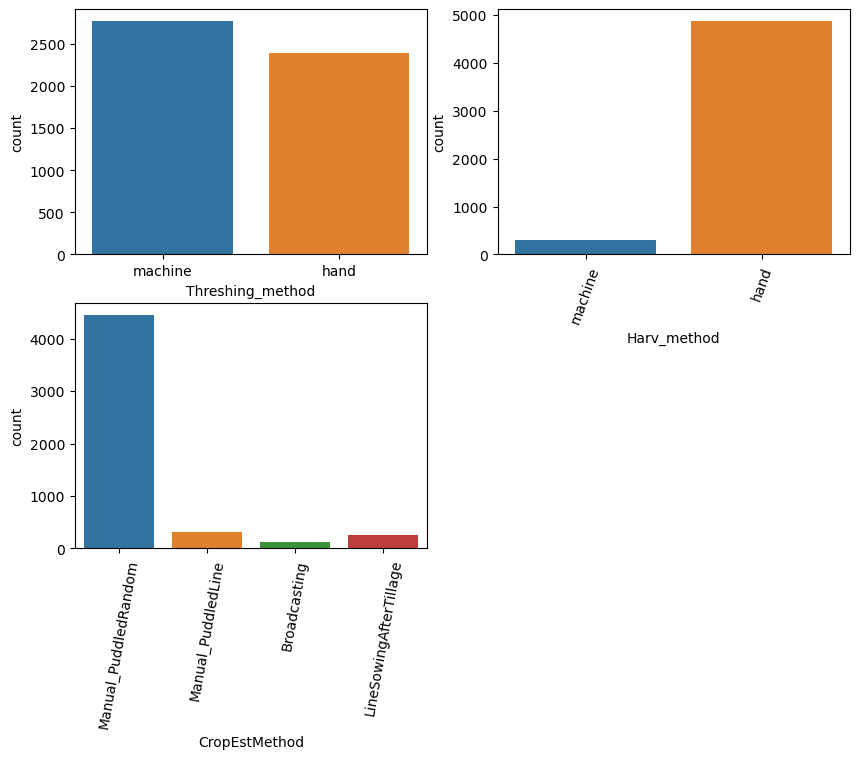

In [38]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 2 ,3)
sns.countplot(x='CropEstMethod' ,data=df )#, hue='District' , order=df['CropEstMethod'].value_counts().index )
plt.xticks(rotation=80)

plt.subplot(2, 2, 2)
sns.countplot(x='Harv_method', data=df )#, hue='District' , order=df['Harv_method'].value_counts().index )
plt.xticks(rotation=70)

plt.subplot(2, 2 , 1)
sns.countplot(x='Threshing_method', data=df )#, hue='District' , order=df['Threshing_method'].value_counts().index )
plt.xticks(rotation=0)

plt.show()


### **we can see from the count plots the follwing :**
- *In harverst hand method is used mostly*
- *In Threshing the used of hand and machine is overlabing.*
- *In transplantation the most used method is Manual_PuddledRandom.*

## **The follwing two features , the first talk about source of water for irrigation ,, and the second talk about the source of power of the pump.**

In [39]:
var_def.loc[['TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource']]

,Description
Variable,
TransplantingIrrigationSource,Source of water for irrigation during transpla...
TransplantingIrrigationPowerSource,Source of power for irrigation pump during tra...


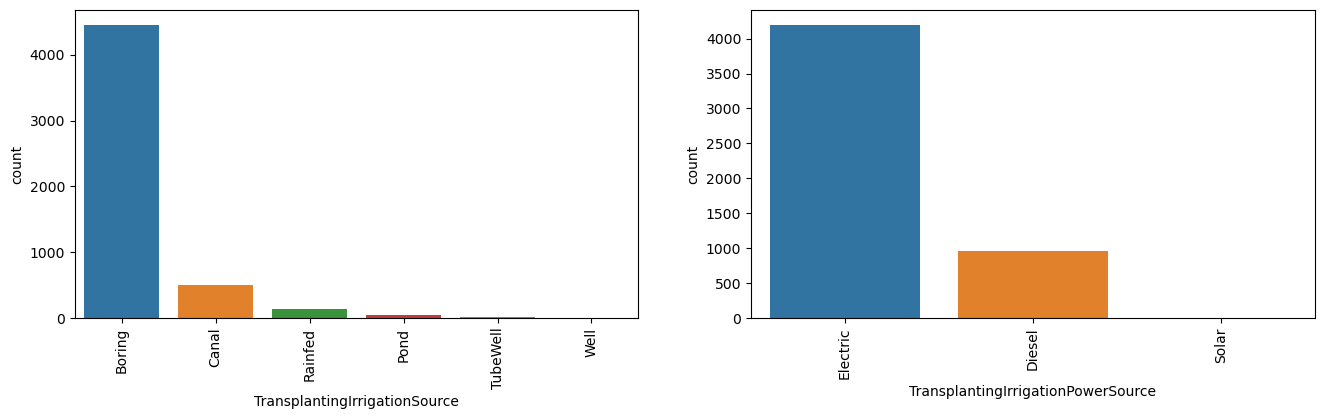

In [40]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='TransplantingIrrigationSource', data=df)
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='TransplantingIrrigationPowerSource', data=df)
plt.xticks(rotation=90)

plt.show()

#### 1- **As we see the in fig(1,1) , The Boring is most source of water used for rice cultivation.**
> *Boring(مياه جوفية) : or "borewell" is  deep hole drilled into the ground to access groundwater reserves , a pump is used to extract water from the underground aquifer and bring it to the surface for various uses, including irrigation.*
#### 2- **In fig(1,2) , The Electric source of power is the most used ,, since pumps need electric power.**
**Other  types of water is Canal Irrigation Systems (جداول من الترع او الانهار) wich it's in several districts.**

---

### *Methods of  fertilization* 

In [41]:
var_def.loc[['PCropSolidOrgFertAppMethod' ,'MineralFertAppMethod' , 'MineralFertAppMethod.1' , 'Stubble_use'] ]

,Description
Variable,
PCropSolidOrgFertAppMethod,Method of applying organic fertilizer in your ...
MineralFertAppMethod,Method of applying chemical fertilizer in your...
MineralFertAppMethod.1,Method of applying chemical fertilizer in your...
Stubble_use,Management practice of the stubble after harve...


### **Here we have 3 features talk about fertilization :**
> * *PCropSolidOrgFertAppMethod : organic fertilizer in your previous crop during land preparation
we see that soil applied (تسميد التربة) is the most used, then Broadcasting (رش الأسمدة).*
>> * *MineralFertAppMethod : chemical fertilizer in your current crop during land preparation.*
>>> * *MineralFertAppMethod.1 : chemical fertilizer in your current crop during second dose.*

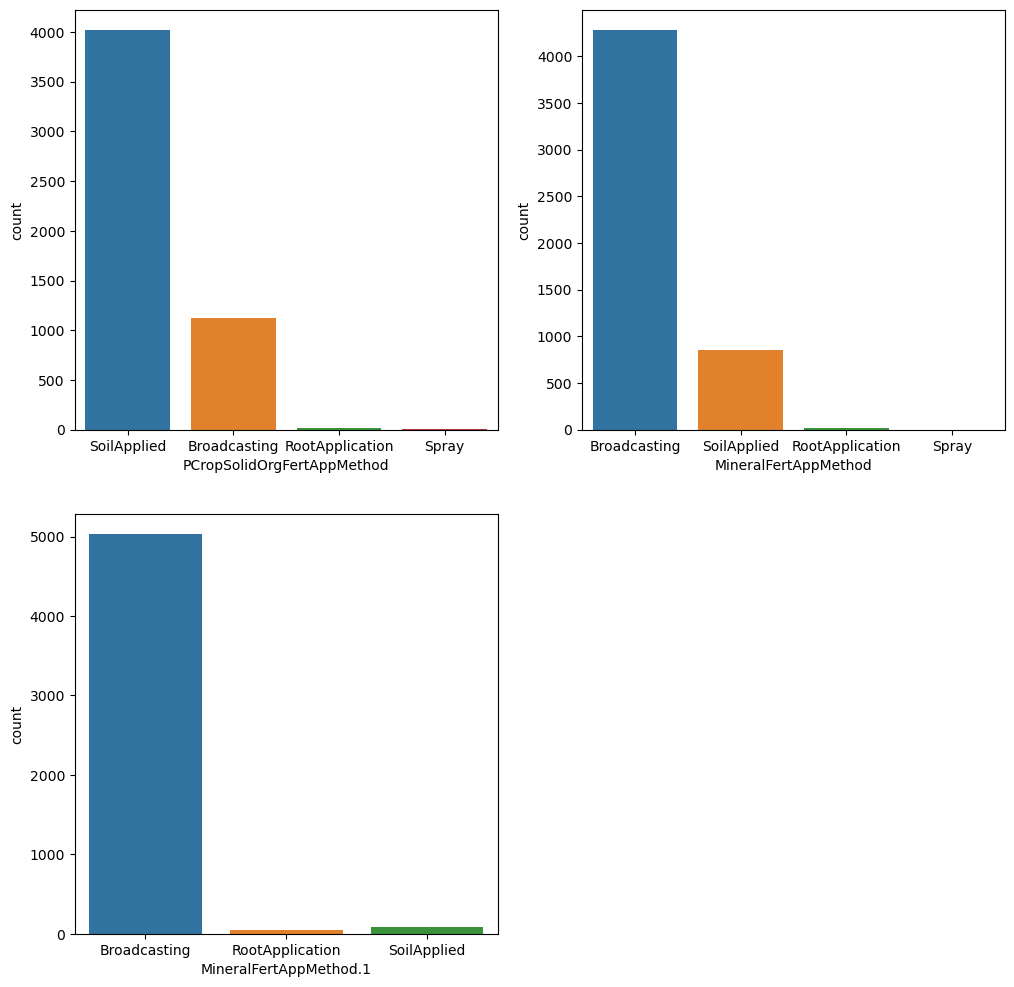

In [42]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
sns.countplot(x='PCropSolidOrgFertAppMethod', data=df)
plt.xticks(rotation=0)

plt.subplot(2, 2, 2)
sns.countplot(x='MineralFertAppMethod', data=df)
plt.xticks(rotation=0)

plt.subplot(2, 2, 3)
sns.countplot(x='MineralFertAppMethod.1', data=df)
plt.xticks(rotation=0)

plt.show()

<AxesSubplot:xlabel='Stubble_use', ylabel='count'>

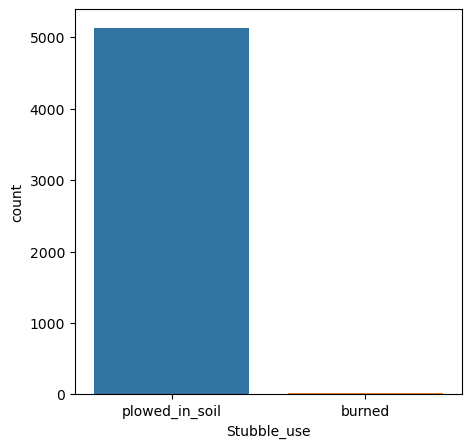

In [43]:
# Management practice of the stubble after harvesting
plt.figure(figsize=(5, 5))
sns.countplot(x='Stubble_use', data=df)

### 💁🏾‍♂️ **We see that we deal with imbalance dataset**

## Numerical features 

In [44]:
var_def.loc[num_col]

,Description
Variable,
CultLand,Area of total cultivated land
CropCultLand,Area of land under cultivation
CropTillageDepth,Depth of the tillage
SeedlingsPerPit,Seedling planted per pit
TransplantingIrrigationHours,Hours of irrigation during transplantation
TransIrriCost,Cost of irrigation during transplantation
StandingWater,How many days of standing water was there in t...
NoFertilizerAppln,Number of times chemical fertilizer has been a...
BasalDAP,Amount of DAP(in kgs)applied during land prepa...


<Figure size 2500x2500 with 0 Axes>

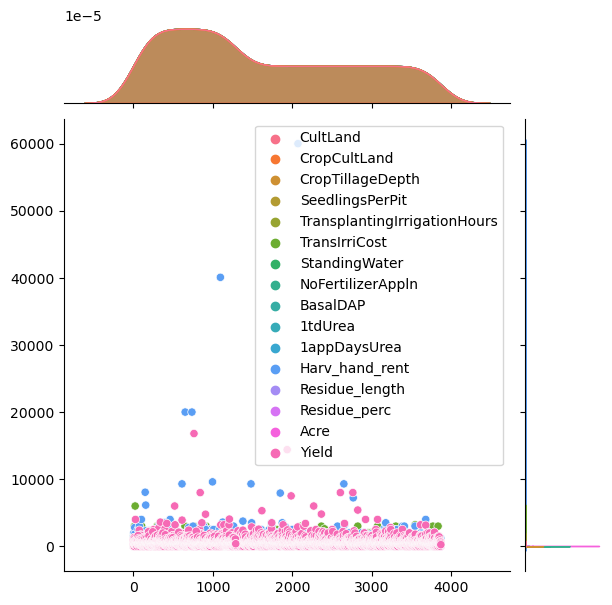

In [45]:
# Joint plot for the numerical data
plt.figure(figsize=(25,25))
sns.jointplot(data=df[num_col])
plt.show()

#### We see that there is a lot of outliers ..

## features distributions 

<Figure size 2000x2000 with 0 Axes>

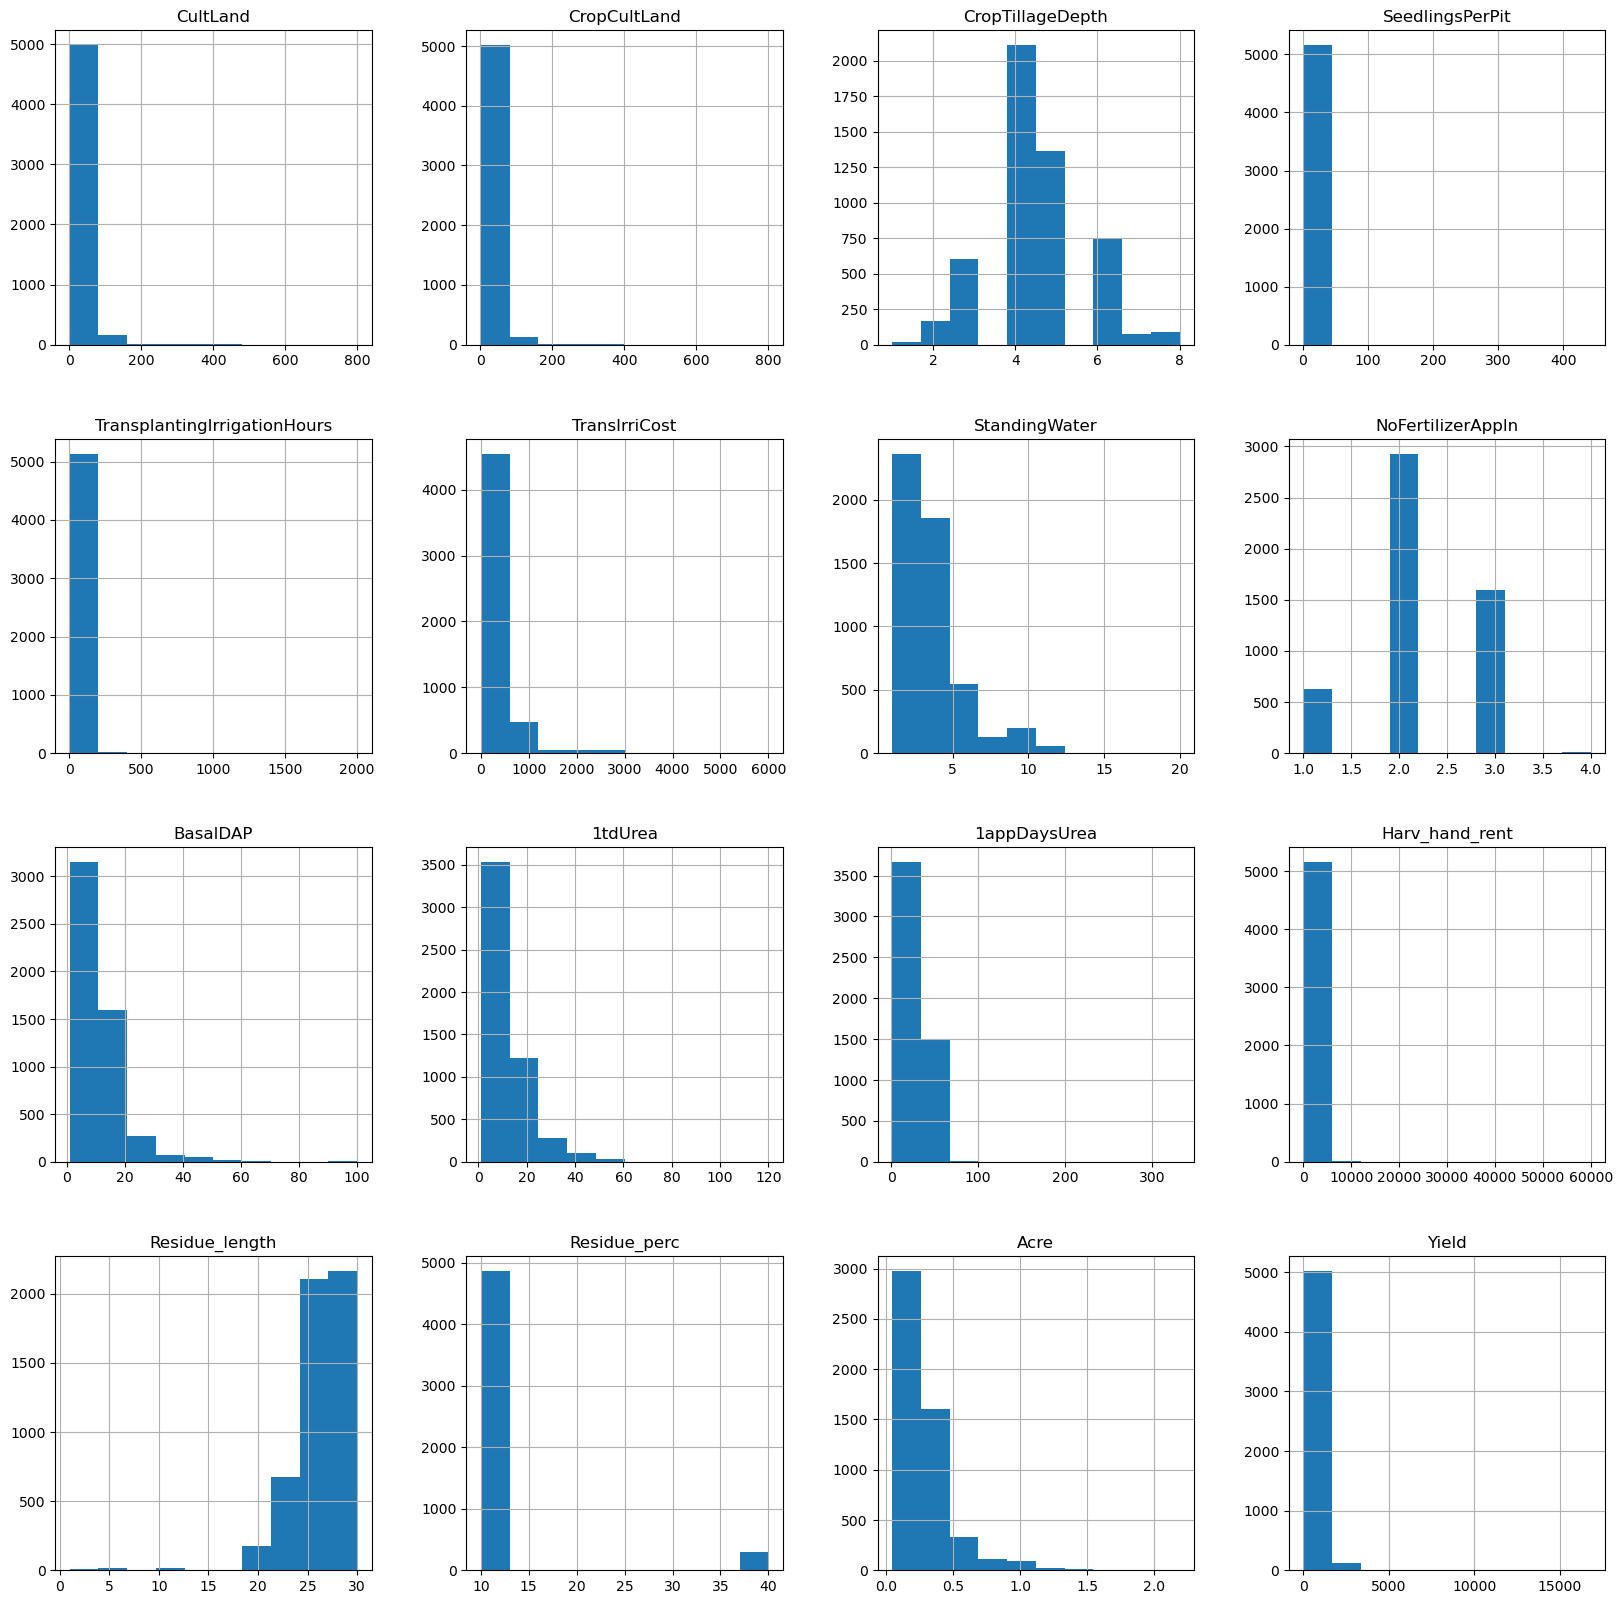

In [46]:
plt.figure(figsize=(20,20))
df[num_col].hist(figsize=(20,20))
plt.show()

# Outliers

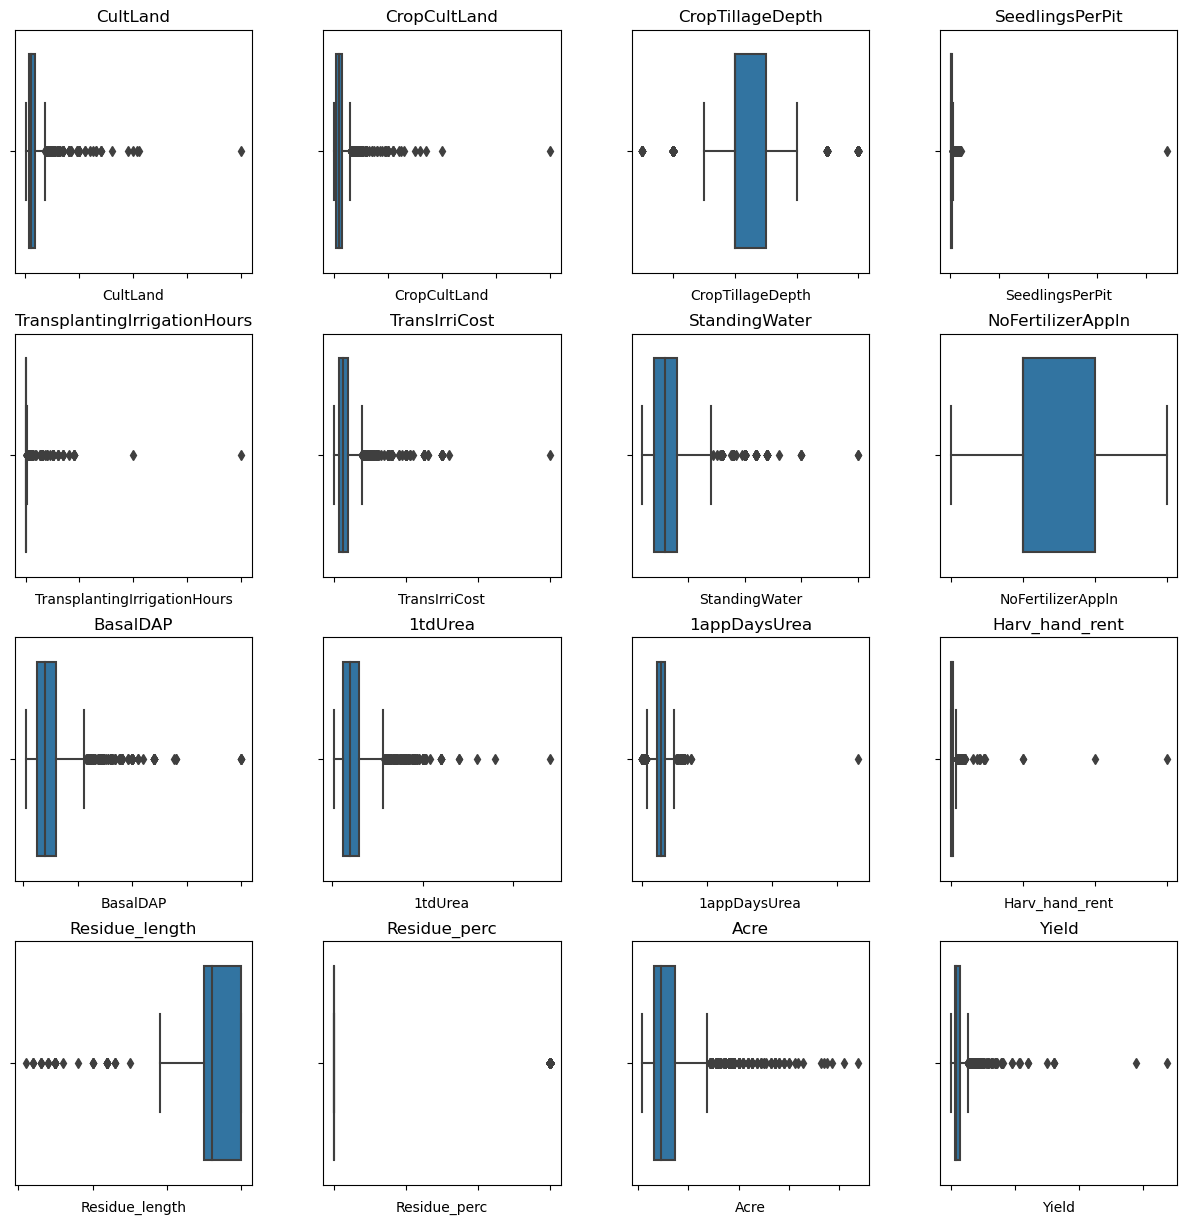

In [47]:
figure, axis = plt.subplots(4, 4, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(num_col[:]):
    row = i//4
    col = i % 4
    bp = sns.boxplot(ax=axis[row, col], x=df[column_name] , hue=df['District'])
    bp.set(xticklabels=[])
    #bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title(column_name)
plt.show()

In [48]:
df[['CultLand' ,'CropCultLand' ,'SeedlingsPerPit' ,'TransplantingIrrigationHours' ,
    'TransIrriCost' ,'TransIrriCost' , 'Residue_perc'  , '1tdUrea' , '1appDaysUrea']].max()


CultLand                        800.00
CropCultLand                    800.00
SeedlingsPerPit                 442.00
TransplantingIrrigationHours   2000.00
TransIrriCost                  6000.00
TransIrriCost                  6000.00
Residue_perc                     40.00
1tdUrea                         120.00
1appDaysUrea                    332.00
dtype: float64

In [49]:
# cut off the max for those features
df = df[df['CultLand'] != 800]
df = df[df['CropCultLand'] != 800]
df = df[df['SeedlingsPerPit'] != 442]
df = df[(df['TransplantingIrrigationHours'] != 2000.0) & (df['TransplantingIrrigationHours'] != 1000)]
df = df[df['TransIrriCost'] != 6000.0]
df = df[df['1tdUrea'] != 120]
df = df[df['1appDaysUrea'] != 332.0]

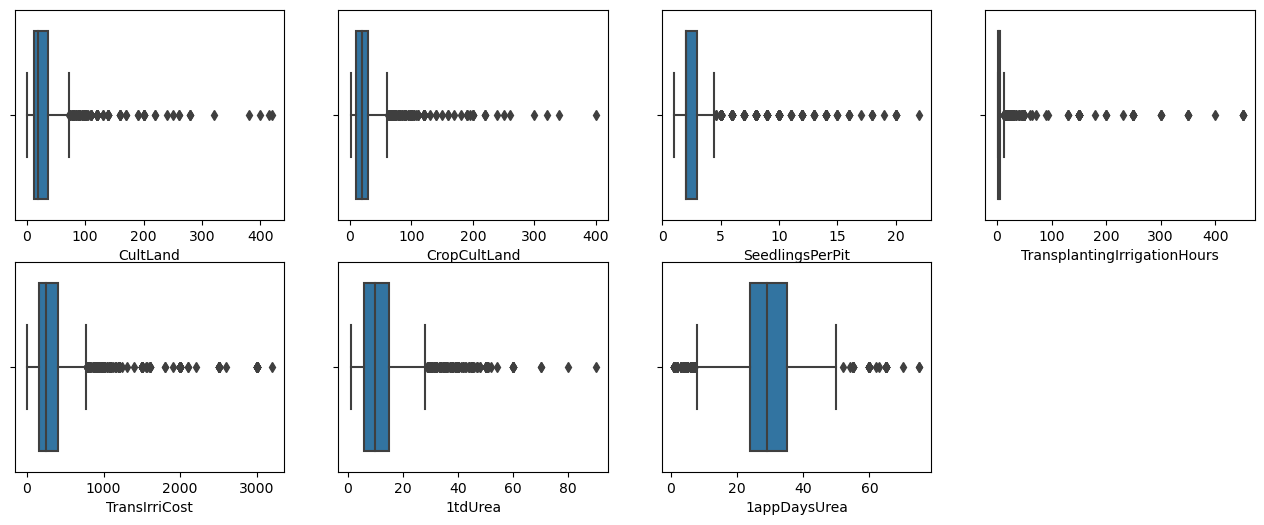

In [50]:
plt.figure(figsize=(16, 6))

plt.subplot(2, 4, 1)
sns.boxplot(x='CultLand', data=df)

plt.subplot(2, 4, 2)
sns.boxplot(x='CropCultLand', data=df)

plt.subplot(2, 4, 3)
sns.boxplot(x='SeedlingsPerPit', data=df)

plt.subplot(2, 4, 4)
sns.boxplot(x='TransplantingIrrigationHours', data=df)

plt.subplot(2, 4, 5)
sns.boxplot(x='TransIrriCost', data=df)

plt.subplot(2, 4, 6)
sns.boxplot(x='1tdUrea', data=df)

plt.subplot(2, 4, 7)
sns.boxplot(x='1appDaysUrea', data=df)

plt.show()

In [51]:
df.shape

(5153, 34)

### **Outliers in the target**

In [52]:
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.96
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    df = df[(df[column] > lower) & (df[column] < upper) ]
    print('Total number of outliers are', df1.shape[0]+ df2.shape[0])
    return   df 
df = out_iqr(df , 'Yield')

The IQR is 402.0
The lower bound value is -487.91999999999996
The upper bound value is 1489.92
Total number of outliers are 247


In [53]:
px.box(data_frame=df , x='Yield')

In [54]:
df = out_iqr(df , 'Acre')

The IQR is 0.16193181818181818
The lower bound value is -0.16113636363636363
The upper bound value is 0.6355681818181818
Total number of outliers are 150


In [55]:
px.box(data_frame=df , x=df['Acre'])

In [56]:
df["Acre_per_Yield"] =(df["Yield"] / df["Acre"])

In [57]:
px.scatter(data_frame=df , x =df['Acre_per_Yield'] , y='Yield')

## Bi variante

In [58]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

In [59]:
season = []
for feat in date_col:
    # Apply function to 'Date' column and create new 'Season' column
    df[f'{feat}_Season'] = df[feat].dt.month.apply(lambda x: get_season(x))
    season += [f'{feat}_Season']
season

['CropTillageDate_Season',
 'RcNursEstDate_Season',
 'Harv_date_Season',
 'Threshing_date_Season',
 'SeedingSowingTransplanting_Season']

### Rice cultivation seasons

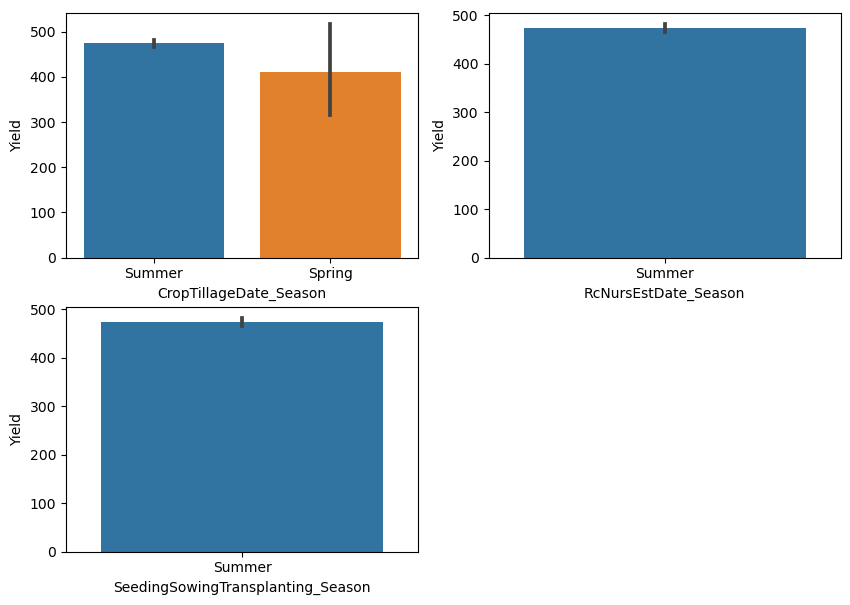

In [60]:
plt.figure(figsize=(10 ,7))
plt.subplot(2,2,1)
sns.barplot(data=df ,x=df['CropTillageDate_Season'] , y=df['Yield'])


plt.subplot(2,2,2)
sns.barplot(data=df ,x=df['RcNursEstDate_Season'] , y=df['Yield'])


plt.subplot(2,2,3)
sns.barplot(data=df ,x=df['SeedingSowingTransplanting_Season'] , y=df['Yield'])


plt.show()

### Rice Harvrest seasons

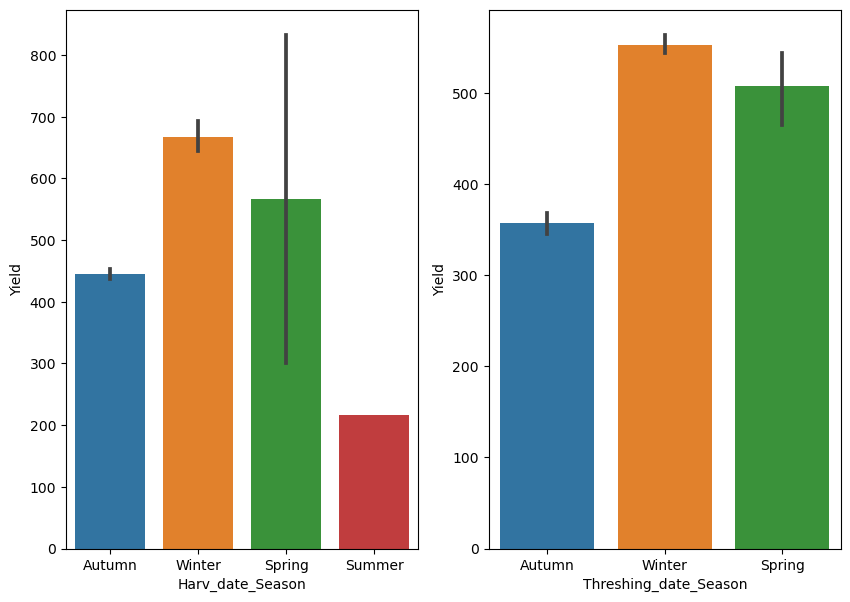

In [61]:
plt.figure(figsize=(10 ,7))

plt.subplot(1,2,1)
sns.barplot(data=df ,x=df['Harv_date_Season'] , y=df['Yield'])


plt.subplot(1,2,2)
sns.barplot(data=df ,x=df['Threshing_date_Season'] , y=df['Yield'])

plt.show()

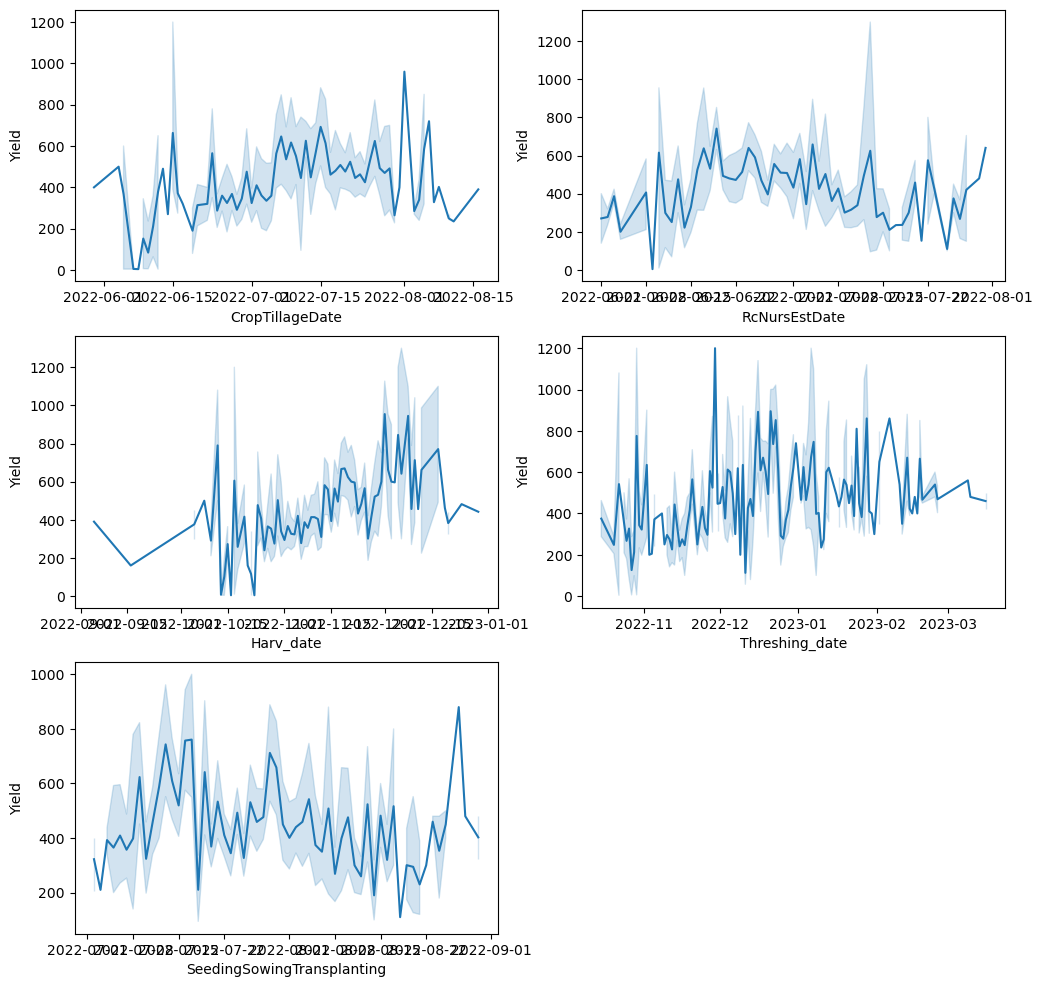

In [62]:
plt.figure(figsize=(12 ,12))
plt.subplot(3,2,1)
sns.lineplot(data=df ,x=df['CropTillageDate'][:500] , y=df['Yield'][:500])
# plt.title("RcNursEstDate vs Yield")

plt.subplot(3,2,2)
sns.lineplot(data=df ,x=df['RcNursEstDate'][:500] , y=df['Yield'][:500])
# plt.title("RcNursEstDate vs Yield")

plt.subplot(3,2,3)
sns.lineplot(data=df ,x=df['Harv_date'][:500] , y=df['Yield'][:500])
# plt.title("RcNursEstDate vs Yield")

plt.subplot(3,2,4)
sns.lineplot(data=df ,x=df['Threshing_date'][:500] , y=df['Yield'][:500])
# plt.title("RcNursEstDate vs Yield")

plt.subplot(3,2,5)
sns.lineplot(data=df ,x=df['SeedingSowingTransplanting'][:500] , y=df['Yield'][:500])
# plt.title("RcNursEstDate vs Yield")


plt.show()

**There is no clear trends acording to date_time columns**

### *Correlated features*

In [63]:
corr_feat = find_highly_correlated_features(df , 0.65)
corr_feat

[('CultLand', 'CropCultLand'), ('BasalDAP', '1tdUrea'), ('Acre', 'Yield')]

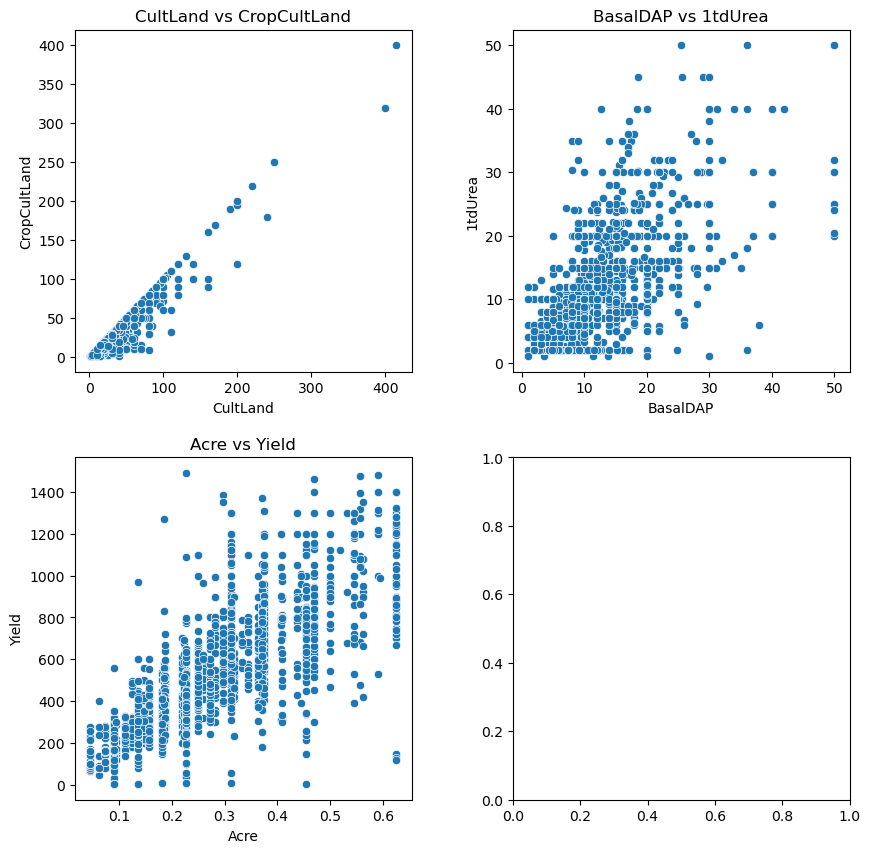

In [64]:
figure, axis = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, (col1 , col2) in enumerate(corr_feat):
    row = i//2
    col = i % 2
    bp = sns.scatterplot(ax=axis[row, col], y=df[col2], x=df[col1]  )
    axis[row, col].set_title(f"{col1} vs {col2}")
plt.show()

In [65]:
df.groupby(df['Harv_method'])['Yield'].sum()

Harv_method
hand      2100293.40
machine    152929.40
Name: Yield, dtype: float64

In [66]:
df.groupby(df['Threshing_method'])['Yield'].sum()


Threshing_method
hand       929285.20
machine   1323937.60
Name: Yield, dtype: float64

In [67]:
df.groupby(df['Stubble_use'])['Yield'].sum()

Stubble_use
burned             15425.00
plowed_in_soil   2237797.80
Name: Yield, dtype: float64

In [68]:
df.groupby(df['District'])['Yield'].sum().sort_values()


District
Vaishali   322312.40
Gaya       387826.60
Jamui      643340.00
Nalanda    899743.80
Name: Yield, dtype: float64

In [69]:
df.groupby(['District'])['Acre'].sum().sort_values()


District
Gaya       186.30
Vaishali   190.05
Jamui      359.68
Nalanda    459.66
Name: Acre, dtype: float64

In [70]:
px.histogram(data_frame=df , x='District' , y='Yield')

## Statistical Tests

In [71]:
import pingouin as pg
for feat in num_col:
    
    df[f"{feat}_out"] = pg.madmedianrule(df[feat])

In [72]:
outliers = [x for x in df.columns if str(x).endswith('out')]
df[outliers].describe().T

,count,unique,top,freq
CultLand_out,4756,2,False,4290
CropCultLand_out,4756,2,False,4370
CropTillageDepth_out,4756,2,False,4668
SeedlingsPerPit_out,4756,2,False,4538
TransplantingIrrigationHours_out,4756,2,False,4541
TransIrriCost_out,4756,2,False,4299
StandingWater_out,4756,2,False,4376
NoFertilizerAppln_out,4756,2,False,2730
BasalDAP_out,4756,2,False,4575
1tdUrea_out,4756,2,False,4418


In [73]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2)
km.fit(df[outliers])
df['clusters'] = km.predict(df[outliers])

In [74]:
# plt.scatter(df.Acre, df['Yield'] , c=clusters, cmap='viridis')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('K-means Clustering')
# plt.show()

In [75]:
df.clusters.value_counts()

0    2730
1    2026
Name: clusters, dtype: int64

In [76]:
corr_feat

[('CultLand', 'CropCultLand'), ('BasalDAP', '1tdUrea'), ('Acre', 'Yield')]

t-test 

In [77]:
train_df = df.loc[df["Set"] == 'Train']

In [78]:
# 1- Harv_method

group1 = train_df[train_df['Harv_method']=="hand"]
print("Group 1 n=",group1.shape[0])
group2 = train_df[train_df['Harv_method']=="machine"]
print("Group 2 n=",group2.shape[0])

pg.ttest(group1["Yield"], group2["Yield"], correction=False)

Group 1 n= 3374
Group 2 n= 194


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.85,3566,two-sided,0.00,"[-181.05, -100.46]",0.51,7.306e+08,1.00


In [79]:
df['Stubble_use'].value_counts()

plowed_in_soil    4734
burned              22
Name: Stubble_use, dtype: int64

* *p_value < 0.05 (level of sgnificant)*
* **we conclud that ther is a difference between the means of two groups**

In [80]:
# 1- Harv_method

group1 = train_df[train_df['Stubble_use']=="plowed_in_soil"]
print("Group 1 n=",group1.shape[0])
group2 = train_df[train_df['Stubble_use']=="burned"]
print("Group 2 n=",group2.shape[0])

pg.mwu(group1["Yield"], group2["Yield"])

Group 1 n= 3548
Group 2 n= 20


,U-val,alternative,p-val,RBC,CLES
MWU,17454.00,two-sided,0.00,0.51,0.25


In [81]:
cat_col

['District',
 'Block',
 'CropEstMethod',
 'TransplantingIrrigationSource',
 'TransplantingIrrigationPowerSource',
 'PCropSolidOrgFertAppMethod',
 'MineralFertAppMethod',
 'MineralFertAppMethod.1',
 'Harv_method',
 'Threshing_method',
 'Stubble_use',
 'Set']

In [97]:
df['PCropSolidOrgFertAppMethod'].value_counts()

SoilApplied        3709
Broadcasting       1031
RootApplication      12
Spray                 4
Name: PCropSolidOrgFertAppMethod, dtype: int64

In [98]:
df.loc[df['PCropSolidOrgFertAppMethod'] == 'Spray' , ['District' , 'Block' , 'Yield']]

,District,Block,Yield
943,Gaya,Gurua,520.00
1677,Vaishali,Mahua,10.00
2475,Jamui,Khaira,240.00
1106,Gaya,Gurua,620.40


In [102]:
df.groupby(['District'])['Yield'].agg(['mean' ,'median' , 'std' , 'min' , 'max'])

,mean,median,std,min,max
District,,,,,
Gaya,534.20,475.50,260.19,80.00,1477.00
Jamui,493.36,400.00,249.39,7.00,1489.60
Nalanda,598.63,560.00,265.48,10.00,1460.00
Vaishali,263.54,242.20,175.95,4.00,1200.00


In [113]:
df.groupby(['District','Block'])['Yield'].agg(['mean' ,'median' , 'std' , 'min' , 'max'])


mean  median    std    min     max
District Block                                          
Gaya     Gurua      578.36  551.00 244.10 165.00 1477.00
         Wazirganj  457.82  400.00 269.76  80.00 1353.40
Jamui    Jamui      453.76  400.00 195.89   7.00 1489.60
         Khaira     548.39  431.00 300.80 100.00 1480.00
Nalanda  Noorsarai  604.16  600.00 254.17 120.00 1400.00
         Rajgir     596.36  560.00 270.08  10.00 1460.00
Vaishali Chehrakala 290.56  286.60 134.66  65.00  967.20
         Garoul     328.86  274.70 199.02   4.00 1080.00
         Mahua      244.58  220.00 183.49   4.00 1200.00

In [112]:
# since lohra is on isolatite point drop it 
df.loc[df['Block'] == 'Lohra' , ['District' ,'Yield' , 'Acre']].index
df.drop(378 , axis=0 , inplace=True)

In [114]:
df.District.value_counts()

Nalanda     1503
Jamui       1303
Vaishali    1222
Gaya         726
Name: District, dtype: int64

In [126]:
def assign_value(District):
    if District == 'Nalanda' or District == 'Gaya':
        return 'zone1'
    elif District == 'Jamui' :
        return 'zone2'
    elif District == 'Vaishali':
        return 'zone3'
    
df['Zone'] = df['District'].apply(assign_value)


In [132]:
df.groupby('Zone')['Yield'].agg(['mean', 'median' , 'sum' , 'min', 'max'])


,mean,median,sum,min,max
Zone,,,,,
zone1,577.64,550.00,1287570.40,10.00,1477.00
zone2,493.12,400.00,642540.00,7.00,1489.60
zone3,263.55,241.60,322062.40,4.00,1200.00


In [129]:
df.groupby(['District','Block','Zone'])['Yield'].agg(['mean', 'median' , 'sum' , 'min', 'max'])

mean  median       sum    min     max
District Block      Zone                                         
Gaya     Gurua      zone1 578.36  551.00 266046.80 165.00 1477.00
         Wazirganj  zone1 457.82  400.00 121779.80  80.00 1353.40
Jamui    Jamui      zone2 453.76  400.00 345313.40   7.00 1489.60
         Khaira     zone2 548.39  431.00 297226.60 100.00 1480.00
Nalanda  Noorsarai  zone1 604.16  600.00 264621.80 120.00 1400.00
         Rajgir     zone1 596.36  560.00 635122.00  10.00 1460.00
Vaishali Chehrakala zone3 290.56  286.60  90072.20  65.00  967.20
         Garoul     zone3 328.86  274.70  34859.00   4.00 1080.00
         Mahua      zone3 244.58  220.00 197131.20   4.00 1200.00

In [130]:
df.groupby('Zone')['Acre'].agg(['mean', 'median' , 'sum' , 'min', 'max'])

,mean,median,sum,min,max
Zone,,,,,
zone1,0.29,0.30,645.96,0.06,0.62
zone2,0.28,0.23,359.23,0.09,0.59
zone3,0.16,0.14,189.91,0.05,0.55


In [131]:
px.pie(data_frame=df , names='Zone' , values='Yield')

In [157]:
season

['CropTillageDate_Season',
 'RcNursEstDate_Season',
 'Harv_date_Season',
 'Threshing_date_Season',
 'SeedingSowingTransplanting_Season']

In [171]:
df.pivot_table(index=['Zone'] , columns=['Harv_date_Season'] , values=['Yield' , 'Yield_per_Acre' , 'Acre'])

Acre                       Yield                       \
Harv_date_Season Autumn Spring Summer Winter Autumn Spring Summer Winter   
Zone                                                                       
zone1              0.29   0.23   0.16   0.29 572.11 566.00 216.20 600.48   
zone2              0.25    NaN    NaN   0.42 441.73    NaN    NaN 847.59   
zone3              0.16    NaN    NaN   0.23 263.36    NaN    NaN 500.00   

                 Yield_per_Acre                          
Harv_date_Season         Autumn  Spring  Summer  Winter  
Zone                                                     
zone1                   2000.63 2291.20 1383.68 2153.51  
zone2                   1754.51     NaN     NaN 1985.53  
zone3                   1722.72     NaN     NaN 2200.00

In [142]:
df['Yield_per_Acre'] =  df['Yield'] / df['Acre']


<AxesSubplot:>

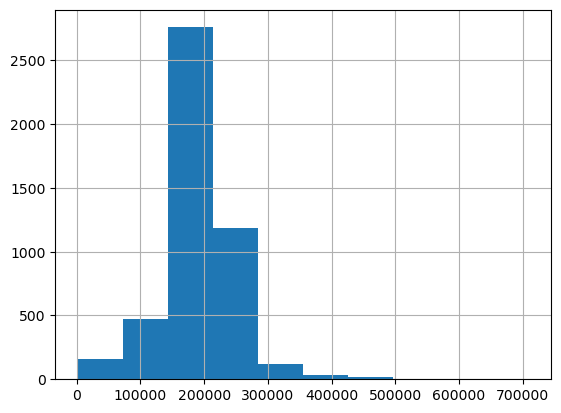

In [141]:
df['Yield_per_Acre'].hist()